## Syntehetic Dataset

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import joblib
import GGMTL as mtl
try:
    from CCMTL import CCMTL
except:
    print('CCMTL package not present, performance may not be as expected')
    CCMTL = None

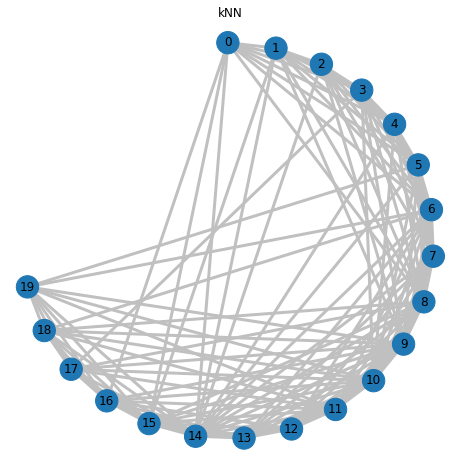

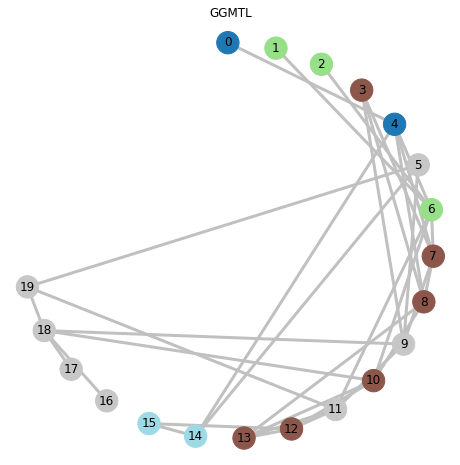

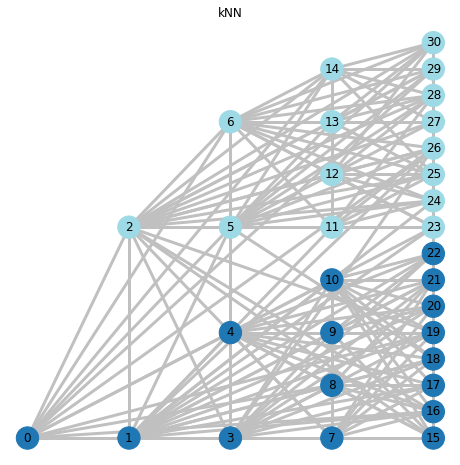

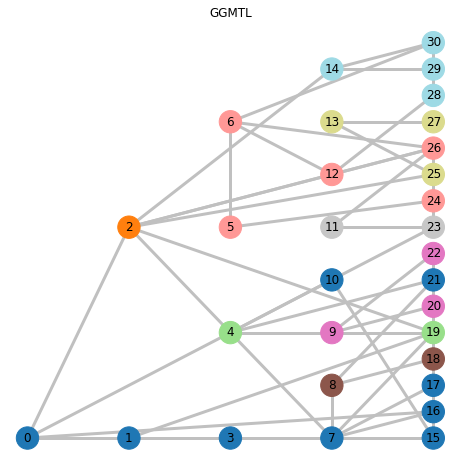

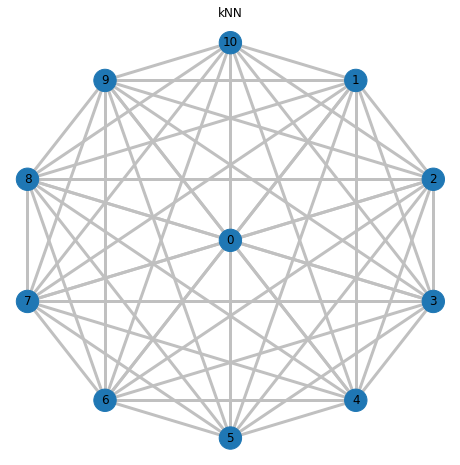

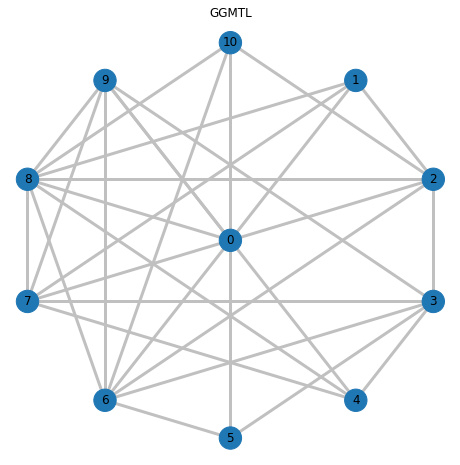

CPU times: user 5.74 s, sys: 182 ms, total: 5.92 s
Wall time: 3.9 s


In [2]:
%%time
path = "dataset/"
dsnames = []
for _ in range(1):
    dsnames+= ["ECML_line_synthetic_repeat{}".format(_)]
    dsnames+= ["ECML_tree_synthetic_repeat{}".format(_)]
    dsnames+= ["ECML_star_synthetic_repeat{}".format(_)]
dataset_global = "synthetic"
k = 10
verbose = False
niterss,xis,etas,gammas,rhos,betas,norm_l21_flags, mus,rhos_mtl = [10], [0],[1],[2],[1],[1e-3],[False],[-.9],[.1]
results_all = []
for dataset_global,dataset_name,filename in mtl.generate_dataset_iter(dsnames,dataset_global,path) :
    results_partial={}
    X_trains, X_tests, y_trains, y_tests = mtl.read_dataset(filename)
    results_partial['dataset'] = [dataset_name,filename,dataset_global] 
    coords = mtl.get_coords(filename)    
    #HPS for CCMTL
    if not CCMTL is None:
        model,rho_mtl,rmse_mtl,best_conf_,results_ = mtl.mtl_hyper_parameter_search(X_trains, X_tests, y_trains, y_tests, CCMTL , rhos_mtl , verbose=False)
        results_partial['mtl'] = [model,rho_mtl,rmse_mtl,best_conf_,results_ ]
    else:
        print("CCMTL package not present: comparison model not trained")
    
    #HPS for GGMTL
    results,best_conf = mtl.hyper_opt_grid_search(X_trains, y_trains, X_tests, y_tests
                              ,niterss,xis,etas,gammas,rhos,betas,norm_l21_flags, mus, rhos_mtl
                              , CCMTL ,k, verbose)
    # results
    ggmtl = best_conf['ggmtl']
    model_sparse = best_conf['model_sparse']
    As = ggmtl.As
    rmse_ggmtl = best_conf['rmse_post']
    rho_ggmtl = best_conf['rho']
    results_partial['ggmtl'] = [results, best_conf, ggmtl, model_sparse,rmse_ggmtl ]
    if not CCMTL is None:
        rmse_perc, nz_perc, rmse_before, rmse_after, ne_before, ne_after = mtl.compare_performances(X_tests,y_tests,model,model_sparse)
        results_partial['compare'] = [rmse_perc, nz_perc, rmse_before, rmse_after, ne_before, ne_after]
    else:
        print("CCMTL package not present: comparision not possible")
    
    results_all+=[results_partial]
    mtl.plot_clustered_graphs(As,"figs/"+dataset_name, inflation=2.1, pos_fix = coords,label_flag=True,use_final_pos_flag=True,use_nodeaslabel=True,knn_different_flag=False,width=3,node_size=500)
    joblib.dump(results_all,"results_{}.joblib".format(dataset_global))

In [3]:
results_all = joblib.load("results_{}.joblib".format(dataset_global))
print("dataset,group,MTL,GGMLT,MTL(#edges),GGMTL(#edges), reduction(%)")
for _1 in results_all:
    if 'compare' in _1:
        rmse_perc, nz_perc, rmse_before, rmse_after, ne_before, ne_after = _1['compare']
        reduction_nz = (ne_before-ne_after)/ne_before*100
        name,rmse1,rmse2 = _1['dataset'][0],*_1['compare'][2:4]
        print("{}, {}, {:.3f}, {:.3f}, {}, {}, {:.1f}".format(name[10:19],name[5:9],rmse1,rmse2,ne_before,ne_after,reduction_nz))

dataset,group,MTL,GGMLT,MTL(#edges),GGMTL(#edges), reduction(%)
synthetic, line, 4.326, 4.325, 200, 36, 82.0
synthetic, tree, 5.173, 5.173, 310, 52, 83.2
synthetic, star, 0.837, 0.731, 110, 38, 65.5
